# Testing for Cointegration Between Ethereum and Bitcoin

In [16]:
# import statements
import pdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.optimize as spop

# Position Class 
"""
    Purpose: Records a singular trade's position data 
"""
class Position():
    def __init__(self, is_asset_1_shorted, entry_time, entry_price_1, entry_price_2, balance, bet_size):      
        self.is_asset_1_shorted = is_asset_1_shorted  # True if asset_1 is shorted, False if longed 
        self.trade_return = None                # holding period return 
        self.entry_time = entry_time 
        self.exit_time = None 
        self.entry_balance = balance 
        self.exit_balance = None 
        self.entry_price_1 = entry_price_1 
        self.entry_price_2 = entry_price_2
        self.exit_price_1 = None
        self.exit_price_2 = None 
        self.max_drawdown = None 
        self.max_drawup = None 
        self.bet_size = bet_size 
    def close_position(self, price_1, price_2, time):
        self.exit_time = time 
        self.exit_price_1 = price_1 
        self.exit_price_2 = price_2

        payoff = 0
        if self.is_asset_1_shorted:
            payoff += self.entry_price_1 - price_1 
            payoff += price_2 - self.entry_price_2
        else:
            payoff += price_1 - self.entry_price_1
            payoff += self.entry_price_2 - price_2
        
        self.trade_return = payoff / (self.entry_price_1 + self.entry_price_2)
        self.exit_balance = self.entry_balance + (self.bet_size * self.trade_return)
        print("TRADE PAYOFF: " + str(self.bet_size * self.trade_return))
        

In [17]:
# Useful functions
"""
price = np.array(btc_data['Open'])
time = np.array(btc_data.index)
"""

"""
    Purpose: Returns a Standard Deviation DataFrame based on the input data

    Inputs:
        data: A Pandas DataFrame Series
        period: length of the Standard Deviation
"""
def get_stdev(data, period):
    data_series = pd.Series(data)
    window = data_series.rolling(period)
    sd = window.std()

    sd_list = sd.tolist()

    df_sd = pd.DataFrame(sd_list, columns=['stdev'])
    df_sd['stdev'] = df_sd['stdev'].fillna(0)
    df_sd.index = data.index

    return df_sd.iloc[period:]['stdev']

"""
    Purpose: Returns a Simple Moving Average DataFrame based on the input data

    Inputs:
        data: A Pandas DataFrame Series
        period: length of the Simple Moving Average
"""
def sma(data, period):

    data_series = pd.Series(data)
    window = data_series.rolling(period)
    moving_averages = window.mean()

    moving_averages_list = moving_averages.tolist()

    df_sma = pd.DataFrame(moving_averages_list, columns=['sma'])
    df_sma['sma'] = df_sma['sma'].fillna(0)
    df_sma.index = data.index
    return df_sma.iloc[period:]['sma']


In [18]:
# Import and format data
btc_data = pd.read_csv('./data/btcusd.csv')
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data = btc_data.set_index('Date')
btc_data = btc_data[(btc_data.index > '2021-06-01') & (btc_data.index <= '2021-10-01')]
btc_data = btc_data.iloc[::10]
btc_data = btc_data.iloc[::-1] # reverse dataframe

eth_data = pd.read_csv('./data/ethusd.csv')
eth_data['Date'] = pd.to_datetime(eth_data['Date'])
eth_data = eth_data.set_index('Date')
eth_data = eth_data[(eth_data.index > '2021-06-01') & (eth_data.index <= '2021-10-01')]
eth_data = eth_data.iloc[::10]
eth_data = eth_data.iloc[::-1]

In [19]:
x = btc_data['Close']
y = eth_data['Close']
df = pd.concat([x, y], axis=1)
df.columns = ['BTC', 'ETH']
df.head()

,BTC,ETH
Date,,
2021-06-01 08:00:00,36201.99,2575.23
2021-06-01 18:00:00,36232.55,2577.65
2021-06-02 04:00:00,36680.09,2625.04
2021-06-02 14:00:00,37875.81,2767.54
2021-06-03 00:00:00,37507.91,2706.96


## Plotting Bitcoin and Ethereum. There's clearly a positive correlation between the two assets.

Text(0.5, 1.0, 'Bitcoin and Ethereum')

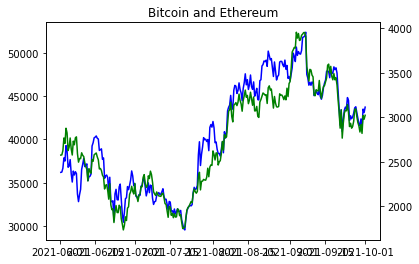

In [20]:
%matplotlib inline
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.plot(df.BTC, color = 'blue', label="Bitcoin")
ax2 = ax.twinx()
ax2.plot(df.ETH, color = 'green', label="Ethereum")
plt.title("Bitcoin and Ethereum")

## Calculating the Spread

In [31]:

model = sm.OLS(df.BTC.iloc[:400], df.ETH.iloc[:400])
model = model.fit()
print(model.params[0])

14.657365060474273


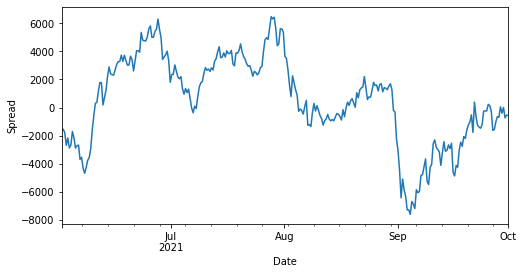

In [32]:
df['spread'] = df.BTC - model.params[0] * df.ETH

df.spread.plot(figsize=(8, 4))
plt.ylabel("Spread")
plt.show()

In [33]:
# Perform ADF Test
from statsmodels.tsa.stattools import adfuller
# Compute ADF test statistics
adf = adfuller(df.spread, maxlag = 1)
adf[0]

-1.822368121987128

In [29]:
adf[4]

{'1%': -3.4529449243622383,
 '5%': -2.871489553425686,
 '10%': -2.572071437887033}

Conclusion: Since -4.08 < -3.44, Portfolio is Stationary and BTC & ETH cointegrated with >99% certainty

# Cointegration Trading Strategy

day 2021-09-13 12:00:00

no trading
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 0.0%

day 2021-09-13 22:00:00

no trading
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 0.0%

day 2021-09-14 08:00:00

no trading
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: 0.0%

day 2021-09-14 18:00:00

long position on BTC and short position on ETH
gross daily return: -0.49%
net daily return: -0.5%
cumulative net return so far: -0.5%

day 2021-09-15 04:00:00

no trading
gross daily return: 0%
net daily return: -0.01%
cumulative net return so far: -0.51%

day 2021-09-15 14:00:00

no trading
gross daily return: 0%
net daily return: 0.0%
cumulative net return so far: -0.51%

day 2021-09-16 00:00:00

long position on BTC and short position on ETH
gross daily return: -0.51%
net daily return: -0.52%
cumulative net return so far: -1.03%

day 2021-09-16 10:00:00

long position on BTC and short position on ETH
gross dail

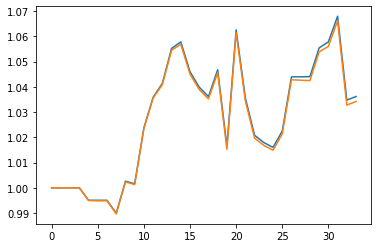

In [25]:
gross_returns = np.array([])
net_returns = np.array([])
t_s = np.array([])
window = 250
fee = 0.0001
t_threshold = -2.5
data = pd.DataFrame()
returns = pd.DataFrame()
data['BTC'] = df.BTC
data['ETH'] = df.ETH
returns['BTC'] = data['BTC'][1:].reset_index(drop=True) / data['BTC'][:-1].reset_index(drop=True)
returns['ETH'] = data['ETH'][1:].reset_index(drop=True) / data['ETH'][:-1].reset_index(drop=True)
times = df.index
asset1 = 'BTC'
asset2 = 'ETH'
for t in range(window, len(data[asset1])-10):
    #define unit root function: stock2 = a + b * stock1
    # unit root function 
    def unit_root(b):
        a = np.average(data[asset2][t-window:t] - b*data[asset1][t-window:t])
        fair_value = a + b*data[asset1][t-window:t]
        diff = np.array(fair_value - data[asset2][t-window:t])
        diff_diff = diff[1:] - diff[:-1]
        reg = sm.OLS(diff_diff, diff[:-1])
        res = reg.fit()
        return res.params[0]/res.bse[0]
    res1 = spop.minimize(unit_root, data[asset2][t]/data[asset1][t], method='Nelder-Mead')
    t_opt = res1.fun
    b_opt = float(res1.x)
    a_opt = np.average(data[asset2][t-window:t] - b_opt*data[asset1][t-window:t])
    fair_value = a_opt + b_opt*data[asset1][t]
    
    #optimising the cointegration equation parameters
    if t == window:
        old_signal = 0
    if t_opt > t_threshold:
        signal = 0
        gross_return = 0
    else:
        signal = np.sign(fair_value - data[asset2][t])
        gross_return = signal*returns[asset2][t] - signal*returns[asset1][t]
    fees = fee*abs(signal - old_signal)
    net_return = gross_return - fees
    gross_returns = np.append(gross_returns, gross_return)
    net_returns = np.append(net_returns, net_return)
    t_s = np.append(t_s, t_opt)
    #simulating trading
    print(f"day {str(data.index[t])}")
    print('')
    if signal == 0:
        print("no trading")
    elif signal == 1:
        print(f"long position on {asset2} and short position on {asset1}")
    else:
        print(f"long position on {asset1} and short position on {asset2}")
    print(f"gross daily return: {str(round(gross_return*100, 2))}%")
    print(f"net daily return: {str(round(net_return*100, 2))}%")
    print(f"cumulative net return so far: {str(round(np.prod(1+net_returns)*100-100, 2))}%")
    print('')
    old_signal = signal

plt.plot(np.append(1, np.cumprod(1+gross_returns)))
plt.plot(np.append(1, np.cumprod(1+net_returns)))
    

Text(0.5, 1.0, 'Bitcoin and Ethereum')

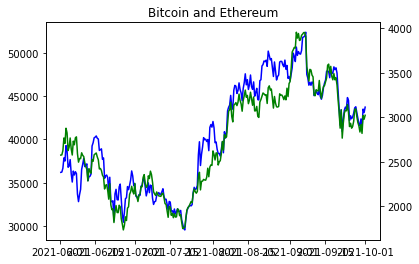

In [26]:
%matplotlib inline
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.plot(df.BTC, color = 'blue', label="Bitcoin")
ax2 = ax.twinx()
ax2.plot(df.ETH, color = 'green', label="Ethereum")
plt.title("Bitcoin and Ethereum")

In [27]:
returns['BTC'][4]

1.0474854504023283

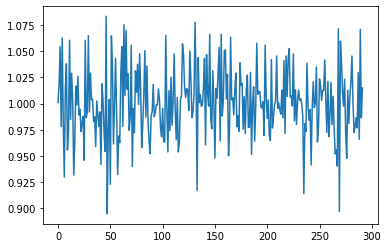

In [34]:
plt.plot(returns['ETH'])